In [94]:
from scipy import stats
import pandas as pd
import numpy as np

# Read data set
hd_df = pd.read_csv('heart disease.csv')

## Show Dataset attributes and descriptive stats

In [95]:
# Dataset makeup
print("Dataset")
print(hd_df.head())
print("\nDataset information")
print(hd_df.info())

# Descriptive statistics
print("\nDescriptive Statistics")
print(hd_df.describe())

# Duplicates?
print("\nDuplicate rows:\n", hd_df[hd_df.duplicated()])

Dataset
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          -------

In [96]:
count_zeros_col = (hd_df['RestingBP'] == 0).sum()
print(f"Number of zeros in RestingBP: {count_zeros_col}")

count_zeros_col = (hd_df['Age'] == 0).sum()
print(f"Number of zeros in Age: {count_zeros_col}")

count_zeros_col = (hd_df['Cholesterol'] == 0).sum()
print(f"Number of zeros in Cholesterol: {count_zeros_col}")

Number of zeros in RestingBP: 1
Number of zeros in Age: 0
Number of zeros in Cholesterol: 172


## Drop rows where certain column values are 0.
### Rows will be fewer than 1% of data set.

In [97]:
# Drop records with RestingBP = 0
hd_df = hd_df[hd_df['RestingBP'] != 0]

# Re-index after dropped rows
hd_df = hd_df.reset_index(drop=True)

## Show unique values of categorical columns for creating dummy variables

In [98]:
# Determine unique values in categorical columns
cat_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

unique_values = {col: hd_df[col].unique().tolist() for col in cat_columns}

for col, values in unique_values.items():
    print(f"Unique values in '{col}': {values}")

Unique values in 'Sex': ['M', 'F']
Unique values in 'ChestPainType': ['ATA', 'NAP', 'ASY', 'TA']
Unique values in 'RestingECG': ['Normal', 'ST', 'LVH']
Unique values in 'ExerciseAngina': ['N', 'Y']
Unique values in 'ST_Slope': ['Up', 'Flat', 'Down']
Unique values in 'FastingBS': [0, 1]


## Transform variables from single character to more descriptive names

In [99]:
# Change M/F to Male/Female so dummy variable column header makes more sense
hd_df['Sex'] = hd_df['Sex'].replace({
    'M': 'Male',
    'F': 'Female'
})

# Change Y/N values to Yes/No so dummy variable column header makes more sense
hd_df['ExerciseAngina'] = hd_df['ExerciseAngina'].replace({
    'N': 'No',
    'Y': 'Yes'
})

# Change 0/1 values to Yes/No so dummy variable column header makes more sense
hd_df['FastingBS'] = hd_df['FastingBS'].replace({
    0: 'No',
    1: 'Yes'
})


## Create binary variables and mapping ordinal values

In [100]:
# Include dummy variables for columns containing binary values
dummy_df1 = pd.get_dummies(hd_df['Sex'], prefix='Sex', drop_first=True, dtype=int)
dummy_df2 = pd.get_dummies(hd_df['ExerciseAngina'], prefix='Ex_Ang', drop_first=True, dtype=int)
dummy_df3 = pd.get_dummies(hd_df['FastingBS'], prefix='FastingBS', drop_first=True, dtype=int)
dummy_df4 = pd.get_dummies(hd_df['ChestPainType'], prefix='ChestPainType', drop_first=True, dtype=int)
dummy_df5 = pd.get_dummies(hd_df['RestingECG'], prefix='RestingECG', drop_first=True, dtype=int)
dummy_df6 = pd.get_dummies(hd_df['ST_Slope'], prefix='ST_Slope', drop_first=True, dtype=int)

hd_df = pd.concat([hd_df, dummy_df1, dummy_df2, dummy_df3, dummy_df4, dummy_df5, dummy_df6], axis=1)


## Create category version of target variable for EDA purposes
#### (Keep binary variable for model learning)

In [101]:
hd_df['HeartDisease_Category'] = hd_df['HeartDisease'].map({0: 'No', 1: 'Yes'})

## Impute values of cholesterol using PMM

In [102]:
# Initialize MICEData with the dataset
from statsmodels.imputation.mice import MICEData
import statsmodels.formula.api as smf

cols_to_include = ['Cholesterol', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Sex_Male', 'Ex_Ang_Yes',
                   'FastingBS_Yes', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
                   'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up']

# Zeros are treated as true values rather than values to be imputed.
# Replacing the zeros with null will allow the impute algorithm to work as intended
hd_df['Cholesterol'] = hd_df['Cholesterol'].replace(0, np.nan)

mice_data_df = hd_df[cols_to_include].copy() # Algorithm requires numeric columns for predictors

mice_data = MICEData(mice_data_df)

# Specify imputation for Cholesterol using numeric columns
predictor_cols = 'Age + RestingBP + MaxHR + Oldpeak + Sex_Male + Ex_Ang_Yes + FastingBS_Yes + ChestPainType_NAP + ChestPainType_TA + RestingECG_Normal + RestingECG_ST + ST_Slope_Flat + ST_Slope_Up'
mice_data.set_imputer('Cholesterol', formula=predictor_cols)

mice_data.update_all(n_iter=10)  # Run MICE for 10 iterations

# Get the imputed dataset
imputed_data = mice_data.data

In [103]:
# Extract only the imputed column Cholesterol and make new column to check imputing results
hd_df['Imputed_Cholesterol'] = imputed_data['Cholesterol']

# Print number of NaN values in original column
print("\nNumber of rows where Cholestoral = NaN: ", hd_df['Cholesterol'].isna().sum())

# Print number of zero values in imputed column
print("\nNumber of rows where Imputed Cholestoral = 0: ",(hd_df['Imputed_Cholesterol'] == 0).sum())

# Print number of NaN values in imputed column
print("\nNumber of rows where Imputed Cholestoral = NaN: ",hd_df['Imputed_Cholesterol'].isna().sum())

# Side-by-side comparison
print("\n",hd_df.loc[hd_df['Imputed_Cholesterol'] != hd_df['Cholesterol'], ['Cholesterol', 'Imputed_Cholesterol']])



Number of rows where Cholestoral = NaN:  171

Number of rows where Imputed Cholestoral = 0:  0

Number of rows where Imputed Cholestoral = NaN:  0

      Cholesterol  Imputed_Cholesterol
293          NaN                265.0
294          NaN                234.0
295          NaN                339.0
296          NaN                267.0
297          NaN                220.0
..           ...                  ...
513          NaN                240.0
514          NaN                225.0
517          NaN                240.0
534          NaN                342.0
535          NaN                258.0

[171 rows x 2 columns]


## Display results after preparation

In [104]:
# Check results
print("Dataset")
print(hd_df.head())
print("\nDataset information")
print(hd_df.info())
# Descriptive statistics
print("\nDescriptive Statistics")
print(hd_df.describe())

Dataset
   Age     Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
0   40    Male           ATA        140        289.0        No     Normal   
1   49  Female           NAP        160        180.0        No     Normal   
2   37    Male           ATA        130        283.0        No         ST   
3   48  Female           ASY        138        214.0        No     Normal   
4   54    Male           NAP        150        195.0        No     Normal   

   MaxHR ExerciseAngina  Oldpeak  ... FastingBS_Yes  ChestPainType_ATA  \
0    172             No      0.0  ...             0                  1   
1    156             No      1.0  ...             0                  0   
2     98             No      0.0  ...             0                  1   
3    108            Yes      1.5  ...             0                  0   
4    122             No      0.0  ...             0                  0   

   ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  RestingECG_ST  \
0       

## Determine distributions

In [105]:
print("Counts of categorical variables")
print("\n",hd_df['HeartDisease_Category'].value_counts())
print("\n",hd_df['Sex'].value_counts())
print("\n",hd_df['ChestPainType'].value_counts())
print("\n",hd_df['FastingBS'].value_counts())
print("\n",hd_df['RestingECG'].value_counts())
print("\n",hd_df['ST_Slope'].value_counts())

Counts of categorical variables

 HeartDisease_Category
Yes    507
No     410
Name: count, dtype: int64

 Sex
Male      724
Female    193
Name: count, dtype: int64

 ChestPainType
ASY    496
NAP    202
ATA    173
TA      46
Name: count, dtype: int64

 FastingBS
No     703
Yes    214
Name: count, dtype: int64

 RestingECG
Normal    551
LVH       188
ST        178
Name: count, dtype: int64

 ST_Slope
Flat    459
Up      395
Down     63
Name: count, dtype: int64


## Perform different analyses

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

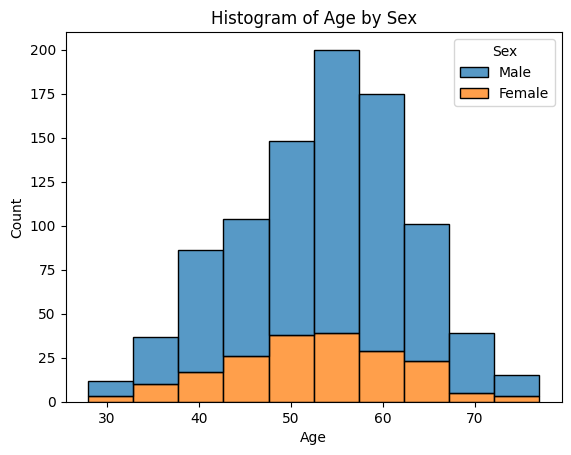

In [110]:
# Plot histogram of Age by Sex
sns.histplot(data=hd_df, x='Age', hue='Sex', multiple='stack', bins=10)
plt.title('Histogram of Age by Sex')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

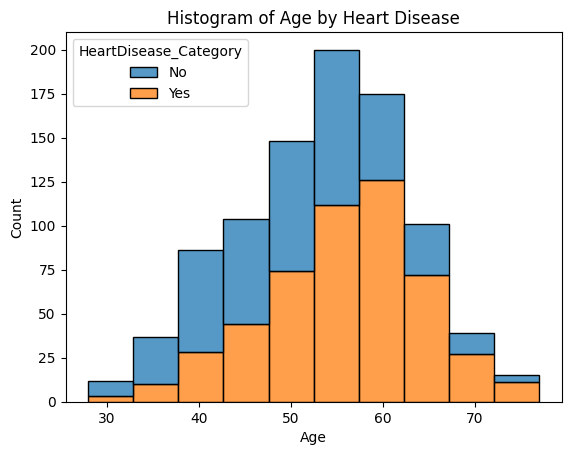

In [111]:
# Plot histogram of Age by Heart Disease
sns.histplot(data=hd_df, x='Age', hue='HeartDisease_Category', multiple='stack', bins=10)
plt.title('Histogram of Age by Heart Disease')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

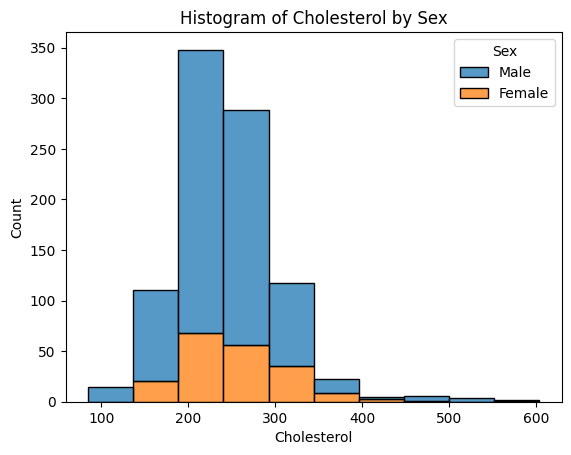

In [112]:
# Plot histogram of Cholesterol by Sex
sns.histplot(data=hd_df, x='Imputed_Cholesterol', hue='Sex', multiple='stack', bins=10)
plt.title('Histogram of Cholesterol by Sex')
plt.xlabel('Cholesterol')
plt.ylabel('Count')
plt.show()

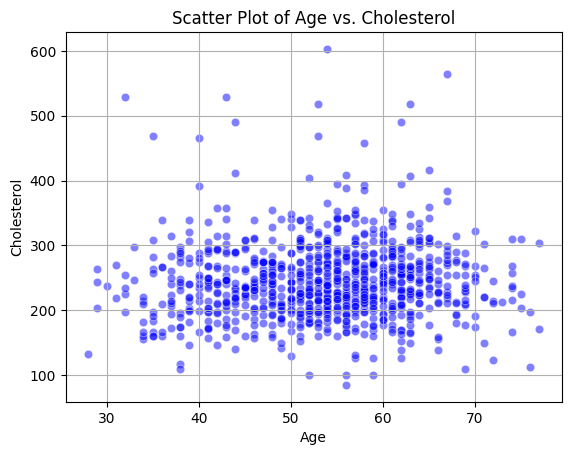

In [113]:
# Plot Scatter Plot of Cholesterol and Age
sns.scatterplot(data=hd_df, x='Age', y='Imputed_Cholesterol', color='blue', alpha=0.5)
plt.title('Scatter Plot of Age vs. Cholesterol')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.grid(True)
plt.show()

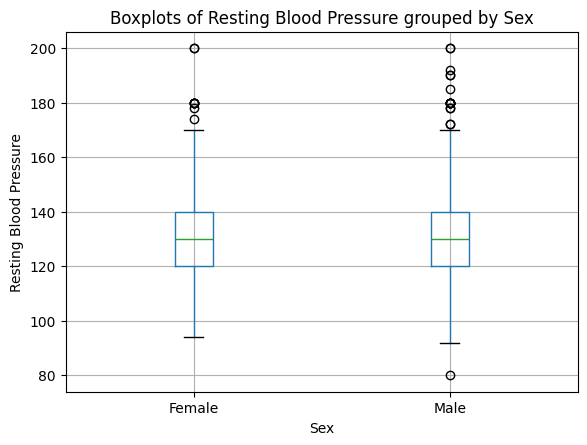

In [114]:
# Plot Box Plot of Resting BP by Sex
hd_df.boxplot(column='RestingBP', by='Sex')
plt.title('Boxplots of Resting Blood Pressure grouped by Sex')
plt.suptitle('')  # Remove default title
plt.xlabel('Sex')
plt.ylabel('Resting Blood Pressure')
plt.show()

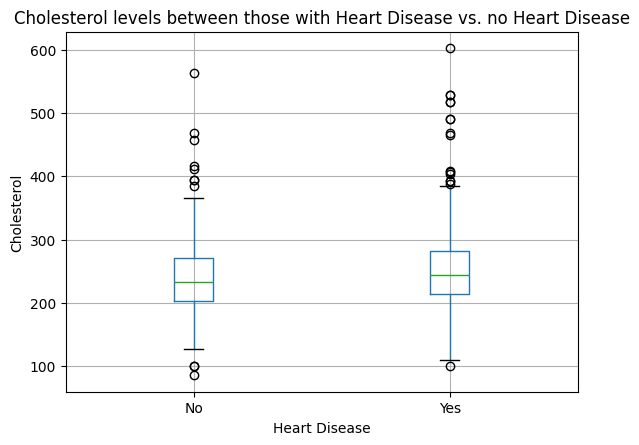

In [115]:
# Plot Box Plot of cholesterol and heart disease
hd_df.boxplot(column='Imputed_Cholesterol', by='HeartDisease_Category')
plt.title('Cholesterol levels between those with Heart Disease vs. no Heart Disease')
plt.suptitle('')  # Remove default title
plt.xlabel('Heart Disease')
plt.ylabel('Cholesterol')
plt.show()

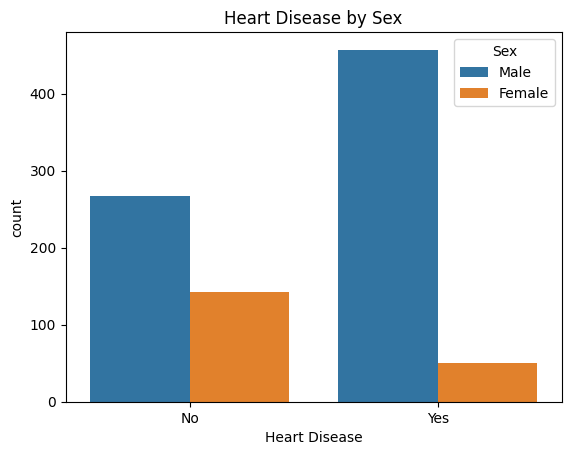

In [116]:
# Grouped Bar Chart of Heart Disease by Sex
sns.countplot(data=hd_df, x='HeartDisease_Category', hue='Sex')
plt.title("Heart Disease by Sex")
plt.xlabel('Heart Disease')
plt.show()

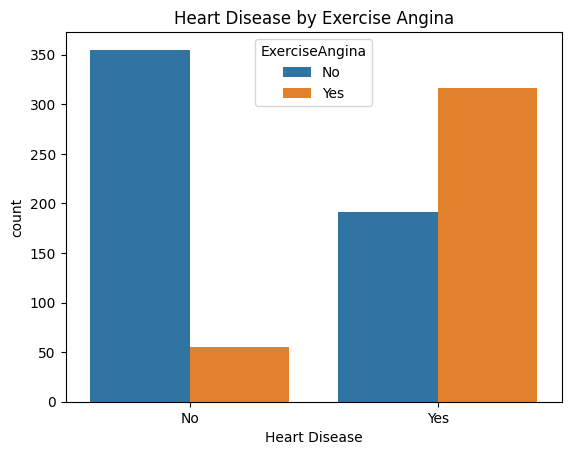

In [117]:
# Grouped Bar Chart of Heart Disease by Exercise Angina
sns.countplot(data=hd_df, x='HeartDisease_Category', hue='ExerciseAngina')
plt.title("Heart Disease by Exercise Angina")
plt.xlabel('Heart Disease')
plt.show()

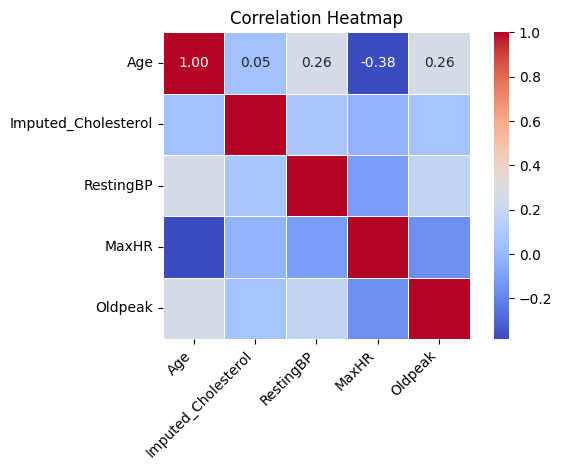

In [120]:
# Compute correlation matrix for only specific columns 
columns_to_correlate = ['Age', 'Imputed_Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak']
corr_matrix = hd_df[columns_to_correlate].corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha='right') # 45-degree angle for x-axis labels
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()